In [3]:
import os
import numpy as np
import pandas as pd
os.environ['NIXTLA_ID_AS_COL'] = '1'
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.utils import AirPassengersDF
from statsforecast.models import AutoETS
from statsforecast.utils import AirPassengers as ap
from statsforecast.models import (
    AutoARIMA, 
    SeasonalNaive,
    AutoETS,
    AutoCES,
    AutoTheta,
    ADIDA,
    CrostonClassic, 
    IMAPA, 
    TSB,
    GARCH,
    ARCH
)
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

c:\Python\Lib\site-packages\statsforecast\core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
Y_df = AirPassengersDF
Y_df.head()
print(Y_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  144 non-null    float64       
 1   ds         144 non-null    datetime64[ns]
 2   y          144 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 3.5 KB
None


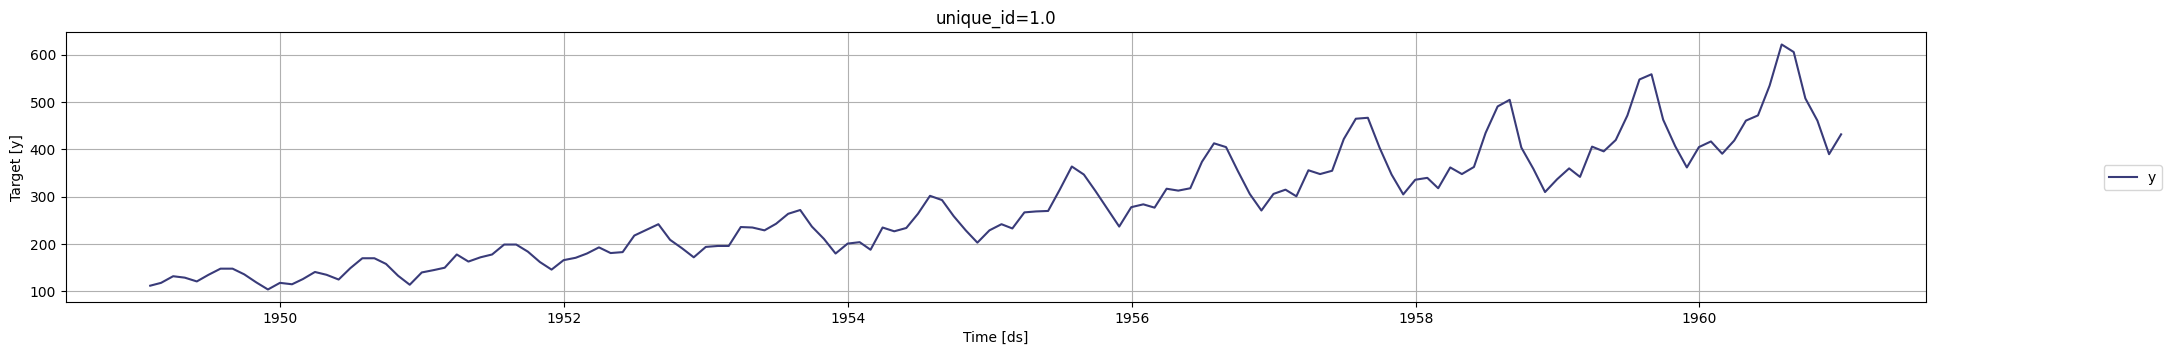

In [3]:
StatsForecast.plot(Y_df)

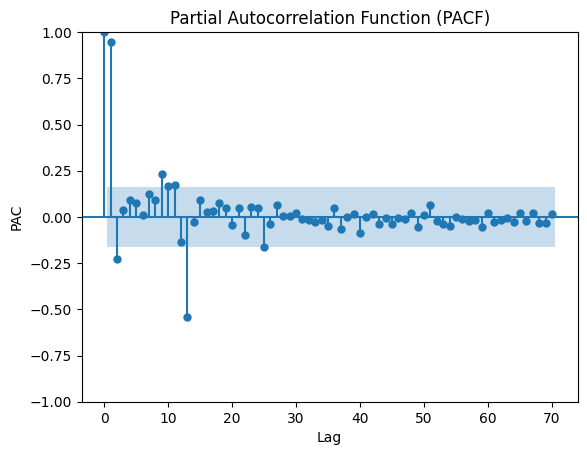

Valores significativos del PAC: [ 1.          0.95467704 -0.26527732  0.28878144  0.20691805  0.2411297
 -0.7183246   0.22160591 -0.20215868]


In [12]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

# Supongamos que 'serie_temporal' es tu serie temporal
# serie_temporal = ...

# Graficar los PAC de la serie temporal
plot_pacf(Y_df.y, lags=70)  # Especifica el número de lags a mostrar, por ejemplo 30
plt.xlabel('Lag')
plt.ylabel('PAC')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Calcular el PAC de la serie temporal
pac_values = pacf(Y_df.y)

# Imprimir los valores del PAC significativos
significant_pac_values = pac_values[(pac_values >= 0.2) | (pac_values <= -0.2)]  # Define un umbral de significancia, por ejemplo, 0.2
print("Valores significativos del PAC:", significant_pac_values)

In [4]:
# Create a list of models and instantiation parameters
season_length = 12
models = [
    AutoARIMA(season_length = season_length),
    SeasonalNaive(season_length=season_length),
    AutoETS(season_length = season_length),
    AutoCES(season_length = season_length),
    AutoTheta(season_length = season_length),
    ADIDA(), 
    CrostonClassic(), 
    IMAPA(), 
    TSB(alpha_d = 0.2, alpha_p = 0.2),
    GARCH(),
    ARCH()
]


In [5]:
# Instantiate StatsForecast class as sf
sf = StatsForecast( 
    models=models,
    freq='M',  # 'D'
    fallback_model = SeasonalNaive(season_length=season_length),
    n_jobs=-1,
)


In [6]:
forecasts_df = sf.forecast(df=Y_df, h=72, level=[90]) #
forecasts_df.head()


,unique_id,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,AutoETS,AutoETS-lo-90,...,IMAPA-hi-90,TSB,TSB-lo-90,TSB-hi-90,"GARCH(1,1)","GARCH(1,1)-lo-90","GARCH(1,1)-hi-90",ARCH(1),ARCH(1)-lo-90,ARCH(1)-hi-90
0,1.0,1961-01-31,444.300049,424.971436,463.628693,417.0,270.681976,563.318054,442.357178,406.054108,...,563.318054,417.0,270.681976,563.318054,247.004761,-37787.796875,38281.808594,218.022812,-29414.894531,29850.939453
1,1.0,1961-02-28,418.210022,394.616974,441.803070,391.0,244.681976,537.318054,428.267365,389.757538,...,537.318054,391.0,244.681976,537.318054,-92.220490,-37470.996094,37286.554688,-65.103592,-18693.701172,18563.494141
2,1.0,1961-03-31,446.237030,418.134003,474.340057,419.0,272.681976,565.318054,492.974792,451.721527,...,565.318054,419.0,272.681976,565.318054,-78.568123,-36475.910156,36318.773438,-50.778419,-15253.988281,15152.431641
3,1.0,1961-04-30,488.228943,456.491608,519.966248,461.0,314.681976,607.318054,477.369995,433.699768,...,607.318054,461.0,314.681976,607.318054,-157.469330,-35585.351562,35270.414062,-102.708649,-15174.583008,14969.166016
4,1.0,1961-05-31,499.231354,464.168854,534.293884,472.0,325.681976,618.318054,477.602814,431.639618,...,618.318054,472.0,325.681976,618.318054,125.527908,-34481.664062,34732.722656,84.555382,-15617.926758,15787.037109


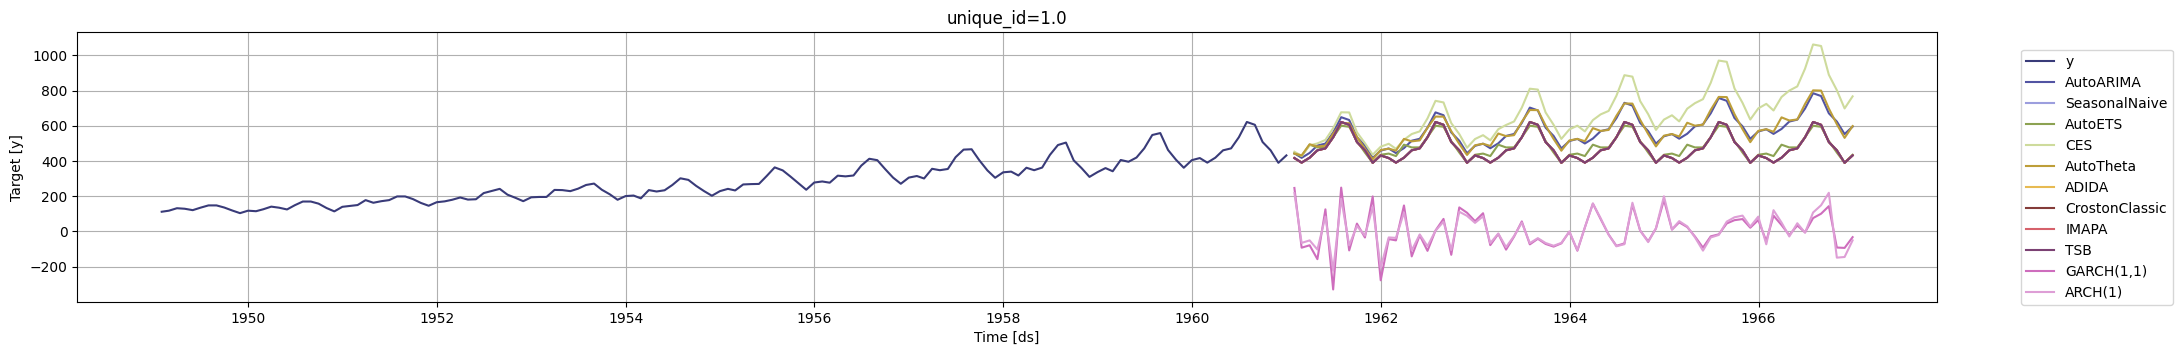

In [7]:
sf.plot(Y_df,forecasts_df)

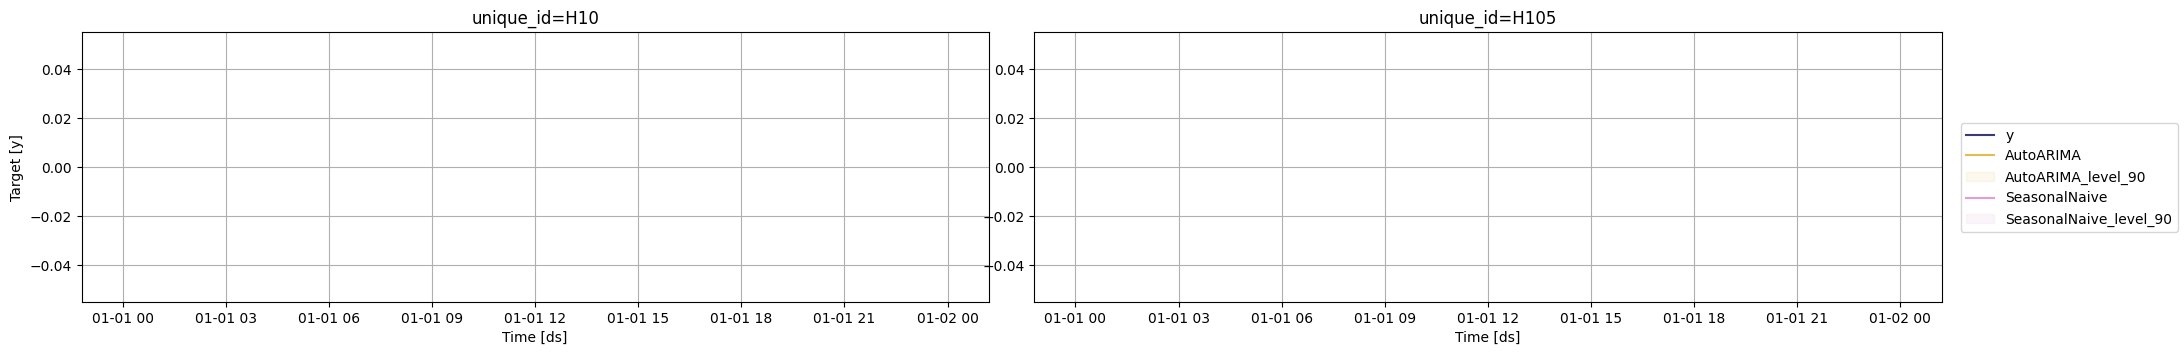

In [8]:
# Plot to unique_ids and some selected models
sf.plot(Y_df, forecasts_df, models=["AutoARIMA","SeasonalNaive"], unique_ids=["H10", "H105"], level=[90])


In [9]:
crossvaldation_df = sf.cross_validation(
    df=Y_df,
    h=24,
    step_size=24,
    n_windows=2
)


In [10]:
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals


In [11]:
evaluation_df = evaluate_cross_validation(crossvaldation_df, mse)
evaluation_df.head()


,AutoARIMA,SeasonalNaive,AutoETS,CES,AutoTheta,ADIDA,CrostonClassic,IMAPA,TSB,"GARCH(1,1)",ARCH(1),best_model
unique_id,,,,,,,,,,,,
1.0,2942.248535,4177.229004,4142.321289,630.850891,1957.806641,9827.605469,9566.027344,9827.605469,8884.285156,191423.5625,184742.46875,CES
